# Introduction and Business Problem
    

##### Introduction:
New York City (NYC), also known as the City of New York or simply New York (NY), is the most populous city in the United States. With an estimated 2018 population of 8,398,748 distributed over a land area of about 302.6 square miles (784 km2), New York is also the most densely populated major city in the United States.

For people that are new to New York, it can be daunting to figure out what restaurants are worth going to and where they are. For people that used to live in New York or are visiting New York, how do you know what the best places are to get something to eat?

##### Business:
For this project, I am going to create a simple guide on where to eat based on Foursquare likes, restaurant category and geographic location data for restaurants in New York. I will then cluster these restaurants based on their similarities so that a user can easily determine what type of restaurants are best to eat at based on Foursquare user feedback.

# Data Required

For this assignment, I will be utilizing the Foursquare API to pull the following location data on restaurants in New York:
    
    Venue Name
    Venue ID
    Venue Location
    Venue Category
    Count of Likes
    
To acquire the data mentioned above, I will need to do the following:

    Get geolocator lat and long coordinates for New York
    Use Foursquare API to get a list of all venues in New York
    Get venue name, venue ID, location, category, and likes

# Algorithm
I will take the gathered data (see above in Data Acquisition Approach and Data Required sections) and will create a k-means clustering algorithm that groups restaurants into 4-5 clusters so that people looking to eat in New York can easily see which restaurants are the best to eat at, what cuisine is available and where in New York they can look to eat.

### Part 1: Getting data from Foursquare

In [81]:

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


#### Finding the geo data for New York

In [82]:
address = 'New york , USA '

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinate of {address} : {latitude}, {longitude}.')

The geograpical coordinate of New York , USA  : 40.7127281, -74.0060152.


#### FourSquare 

In [83]:
# Define Foursquare Credentials and Version
LIMIT = 1000 # limit of number of venues returned by Foursquare API

CLIENT_ID = 'QT2UDRDVHUR2RDHG42LH1NPGWHRJSSW2AJBCQGTAF2YHZILD' # your Foursquare ID
CLIENT_SECRET = 'QQR1J2K5V12LDEDGRK42HNVPJPSHVBMXCJFXWYNEFA0CEAX2' # your Foursquare Secret
VERSION = '20191205'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QT2UDRDVHUR2RDHG42LH1NPGWHRJSSW2AJBCQGTAF2YHZILD
CLIENT_SECRET:QQR1J2K5V12LDEDGRK42HNVPJPSHVBMXCJFXWYNEFA0CEAX2


In [84]:
radius = 5000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=QT2UDRDVHUR2RDHG42LH1NPGWHRJSSW2AJBCQGTAF2YHZILD&client_secret=QQR1J2K5V12LDEDGRK42HNVPJPSHVBMXCJFXWYNEFA0CEAX2&v=20191205&ll=40.7127281,-74.0060152&radius=5000&limit=1000'

In [85]:
results = requests.get(url).json()
# results

#### Now we start pulling the data from Foursquare into a dataframe so we can manipulate and use it.

In [86]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [87]:

#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.head()

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802
1,Korin,4af5d65ff964a52091fd21e3,Furniture / Home Store,40.714824,-74.009404
2,Aire Ancient Baths,4fbbd9ede4b0756c0d4c2364,Spa,40.718141,-74.004941
3,9/11 Memorial North Pool,58801864cc5b6a14dedce689,Memorial Site,40.712077,-74.013187
4,One World Trade Center,4abe7f9ef964a520068e20e3,Building,40.713069,-74.013133


#### rename columns

In [88]:
#fix the column names so they look relatively normal

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,id,categories,lat,lng
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802
1,Korin,4af5d65ff964a52091fd21e3,Furniture / Home Store,40.714824,-74.009404
2,Aire Ancient Baths,4fbbd9ede4b0756c0d4c2364,Spa,40.718141,-74.004941
3,9/11 Memorial North Pool,58801864cc5b6a14dedce689,Memorial Site,40.712077,-74.013187
4,One World Trade Center,4abe7f9ef964a520068e20e3,Building,40.713069,-74.013133


In [89]:
nearby_venues.shape

(100, 5)

In [90]:
# find a list of unique categories from the API so we can see what may or may not fit for restaurants

nearby_venues['categories'].unique()

array(['Hotel Bar', 'Furniture / Home Store', 'Spa', 'Memorial Site',
       'Building', 'Playground', 'New American Restaurant', 'Yoga Studio',
       'Restaurant', 'Coffee Shop', 'Park', 'Salad Place', 'Music Venue',
       'French Restaurant', 'Bridge', 'Wine Bar', 'Cocktail Bar',
       'Greek Restaurant', 'Plaza', 'Indie Movie Theater',
       'Thai Restaurant', 'Chocolate Shop', 'Mediterranean Restaurant',
       'Hotel', 'Italian Restaurant', 'Garden',
       'Paper / Office Supplies Store', 'Grocery Store', 'Bookstore',
       'Shoe Store', 'Theme Park Ride / Attraction', 'Snack Place',
       'Café', 'Beach', 'Pilates Studio', 'Pizza Place', 'Movie Theater',
       'Jewelry Store', 'Udon Restaurant', 'Asian Restaurant',
       'Club House', 'Scenic Lookout', 'Gourmet Shop', 'Boxing Gym',
       'Sandwich Place', 'Beer Store', 'Ice Cream Shop', 'Wine Shop',
       'Cycle Studio', 'Pier', 'Comedy Club', 'Cheese Shop',
       'Soccer Field', 'Dog Run', 'Gym / Fitness Center',
   

In [91]:
# creating a list of categorie to remove from our dataframe because they are not restaurants
# I am sure there is a function that can be written to do this at scale but since it was a small list, I did it manually

removal_list = ['Hotel Bar', 'Furniture / Home Store', 'Spa', 'Memorial Site',
       'Building', 'Playground', 'Yoga Studio',
       'Park', 'Salad Place', 'Music Venue',
        'Bridge', 'Plaza', 'Indie Movie Theater',
       'Chocolate Shop', 
       'Hotel',  'Garden',
       'Paper / Office Supplies Store', 'Grocery Store', 'Bookstore',
       'Shoe Store', 'Theme Park Ride / Attraction',
       'Beach', 'Pilates Studio',  'Movie Theater',
       'Jewelry Store', 
       'Club House', 'Scenic Lookout', 'Gourmet Shop', 'Boxing Gym',
       'Wine Shop',
       'Cycle Studio', 'Pier', 'Comedy Club', 'Cheese Shop',
       'Soccer Field', 'Dog Run', 'Gym / Fitness Center',
       'Theater', 'Cosmetics Shop', 'Trail',
       'Art Gallery',
       'Bagel Shop', 'Stationery Store']
nearby_venues2 = nearby_venues.copy()


#getting a clear dataframe of just restaurants
nearby_venues2 = nearby_venues2[~nearby_venues2['categories'].isin(removal_list)]
nearby_venues2

,name,id,categories,lat,lng
6,Manhatta,5ada32224f0e584592628c1f,New American Restaurant,40.707654,-74.009138
10,Crown Shy,5c883f65f4b525002c0bf2ca,Restaurant,40.706187,-74.007490
11,Black Fox Coffee Co.,574456e5498e39c73d234da1,Coffee Shop,40.706573,-74.008155
15,Le Coucou,57583641498e90001a32e13e,French Restaurant,40.719114,-74.000202
20,La Compagnie des Vins Surnaturels,53506fd9498ebca706a7c170,Wine Bar,40.720448,-73.997969
21,The Dead Rabbit,50bcb93ae4b0efcb4c84d434,Cocktail Bar,40.703051,-74.010992
22,Kiki's,5521c2ff498ebe2368634187,Greek Restaurant,40.714476,-73.992036
25,Wayla,5cc4e9d0c876c8002c3010cb,Thai Restaurant,40.718291,-73.992584
27,CAVA,59e0ee84f0ca95526b7fce9f,Mediterranean Restaurant,40.721928,-73.996512
31,Rubirosa Ristorante,4cc6222106c25481d7a4a047,Italian Restaurant,40.722706,-73.995957


In [92]:
neighborhoods = nearby_venues2
neighborhoods=neighborhoods.rename(columns={"lat": "Latitude", "lng": "Longitude"})
neighborhoods.head()

,name,id,categories,Latitude,Longitude
6,Manhatta,5ada32224f0e584592628c1f,New American Restaurant,40.707654,-74.009138
10,Crown Shy,5c883f65f4b525002c0bf2ca,Restaurant,40.706187,-74.007490
11,Black Fox Coffee Co.,574456e5498e39c73d234da1,Coffee Shop,40.706573,-74.008155
15,Le Coucou,57583641498e90001a32e13e,French Restaurant,40.719114,-74.000202
20,La Compagnie des Vins Surnaturels,53506fd9498ebca706a7c170,Wine Bar,40.720448,-73.997969


Now let's get a list of venue ids so we can pull likes and add to our dataframe.

In [93]:
#let's get a list of venues

venue_id_list = neighborhoods['id'].tolist()

In [94]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[178, 106, 406, 370, 421, 2016, 825, 91, 105, 2466, 1027, 1120, 242, 143, 74, 870, 420, 355, 91, 435, 327, 652, 33, 627, 1831, 584, 1152, 1142, 1385, 187, 391, 203, 234, 693, 45]


In [95]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

35
35


### Part 2: Data preparation
The thought process behind this is that likes are a proxy for quality. The more likes there are, the better the restaurant is.  I will then bin this data into a quality categorical variables so we can cluster appropriately.

In [96]:
#let's make a copy of our initial dataframe just in case anything goes wrong
NY_venues = neighborhoods.copy()
NY_venues.head()

,name,id,categories,Latitude,Longitude
6,Manhatta,5ada32224f0e584592628c1f,New American Restaurant,40.707654,-74.009138
10,Crown Shy,5c883f65f4b525002c0bf2ca,Restaurant,40.706187,-74.007490
11,Black Fox Coffee Co.,574456e5498e39c73d234da1,Coffee Shop,40.706573,-74.008155
15,Le Coucou,57583641498e90001a32e13e,French Restaurant,40.719114,-74.000202
20,La Compagnie des Vins Surnaturels,53506fd9498ebca706a7c170,Wine Bar,40.720448,-73.997969


In [97]:
# add in the list of likes

NY_venues['total likes'] = like_list
NY_venues.head()

,name,id,categories,Latitude,Longitude,total likes
6,Manhatta,5ada32224f0e584592628c1f,New American Restaurant,40.707654,-74.009138,178
10,Crown Shy,5c883f65f4b525002c0bf2ca,Restaurant,40.706187,-74.007490,106
11,Black Fox Coffee Co.,574456e5498e39c73d234da1,Coffee Shop,40.706573,-74.008155,406
15,Le Coucou,57583641498e90001a32e13e,French Restaurant,40.719114,-74.000202,370
20,La Compagnie des Vins Surnaturels,53506fd9498ebca706a7c170,Wine Bar,40.720448,-73.997969,421


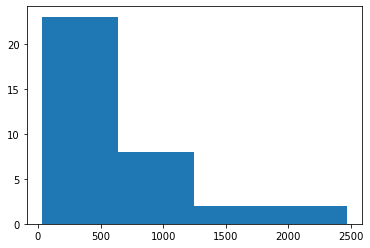

In [98]:
# let's visualize our total likes based on a histogram
import matplotlib.pyplot as plt
NY_venues['total likes'].hist(bins=4)
plt.grid(b=None)
plt.show()

In [99]:
# what are the bins we want to use?
low = np.percentile(NY_venues['total likes'], 25)
average=np.percentile(NY_venues['total likes'], 50)
high=np.percentile(NY_venues['total likes'], 75)

print(np.percentile(NY_venues['total likes'], 25))
print(np.percentile(NY_venues['total likes'], 50))
print(np.percentile(NY_venues['total likes'], 75))

182.5
406.0
847.5


In [100]:
# now we have our bin values so let's set them to the appropriate values
# less than 182, 182-406, 406-847, >847
# poor, below avg, abv avg, great

poor = NY_venues['total likes']<=low
below_avg = NY_venues[(NY_venues['total likes']>low) & (NY_venues['total likes']<=average)]
abv_avg = NY_venues[(NY_venues['total likes']>average) & (NY_venues['total likes']<=high)]
great = NY_venues['total likes']>high

In [101]:
# let's set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=low:
        return 'poor'
    if s['total likes']<=average:
        return 'below avg'
    if s['total likes']<=high:
        return 'above avg'
    else:
        return 'great'

NY_venues['total likes_cat']=NY_venues.apply(conditions, axis=1)

In [102]:
NY_venues.head()

,name,id,categories,Latitude,Longitude,total likes,total likes_cat
6,Manhatta,5ada32224f0e584592628c1f,New American Restaurant,40.707654,-74.009138,178,poor
10,Crown Shy,5c883f65f4b525002c0bf2ca,Restaurant,40.706187,-74.007490,106,poor
11,Black Fox Coffee Co.,574456e5498e39c73d234da1,Coffee Shop,40.706573,-74.008155,406,below avg
15,Le Coucou,57583641498e90001a32e13e,French Restaurant,40.719114,-74.000202,370,below avg
20,La Compagnie des Vins Surnaturels,53506fd9498ebca706a7c170,Wine Bar,40.720448,-73.997969,421,above avg


In [103]:
# let's star the process for re-categorizing the categories
NY_venues['categories'].unique()

array(['New American Restaurant', 'Restaurant', 'Coffee Shop',
       'French Restaurant', 'Wine Bar', 'Cocktail Bar',
       'Greek Restaurant', 'Thai Restaurant', 'Mediterranean Restaurant',
       'Italian Restaurant', 'Snack Place', 'Café', 'Pizza Place',
       'Udon Restaurant', 'Asian Restaurant', 'Sandwich Place',
       'Beer Store', 'Ice Cream Shop', 'Sushi Restaurant',
       'Peruvian Restaurant', 'Seafood Restaurant', 'Moroccan Restaurant',
       'Tea Room', 'Steakhouse', 'Bakery', 'Beer Bar'], dtype=object)

In [117]:
# let's create our new categories and create a function to apply those to our existing data

bars = ['Wine Bar' ,'Cocktail Bar','Beer Store','Beer Bar']
snack = ['Coffee Shop', 'Mediterranean Restaurant', 'Snack Place','Tea Room', 'Bakery',
        'Café', 'Sandwich Place','Ice Cream Shop']
euro_food = ['French Restaurant', 'Greek Restaurant',
            'Italian Restaurant', 'Moroccan Restaurant']
asia_food =['Thai Restaurant','Udon Restaurant', 'Sushi Restaurant','Asian Restaurant',]
american_food = ['New American Restaurant', 'Restaurant','Peruvian Restaurant','Steakhouse','Seafood Restaurant']
italian_food = ['Italian Restaurant', 'Pizza Place']

def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in other:
        return 'other'
    if s['categories'] in euro_food:
        return 'euro food'
    if s['categories'] in asia_food:
        return 'asia food'
    if s['categories'] in american_food:
        return 'american food'
    if s['categories'] in italian_food:
        return 'italian food'

NY_venues['categories_new']=NY_venues.apply(conditions2, axis=1)

In [118]:
NY_venues

,name,id,categories,Latitude,Longitude,total likes,total likes_cat,categories_new,label
6,Manhatta,5ada32224f0e584592628c1f,New American Restaurant,40.707654,-74.009138,178,poor,american food,1
10,Crown Shy,5c883f65f4b525002c0bf2ca,Restaurant,40.706187,-74.007490,106,poor,american food,1
11,Black Fox Coffee Co.,574456e5498e39c73d234da1,Coffee Shop,40.706573,-74.008155,406,below avg,other,0
15,Le Coucou,57583641498e90001a32e13e,French Restaurant,40.719114,-74.000202,370,below avg,euro food,0
20,La Compagnie des Vins Surnaturels,53506fd9498ebca706a7c170,Wine Bar,40.720448,-73.997969,421,above avg,bars,2
21,The Dead Rabbit,50bcb93ae4b0efcb4c84d434,Cocktail Bar,40.703051,-74.010992,2016,great,bars,3
22,Kiki's,5521c2ff498ebe2368634187,Greek Restaurant,40.714476,-73.992036,825,above avg,euro food,2
25,Wayla,5cc4e9d0c876c8002c3010cb,Thai Restaurant,40.718291,-73.992584,91,poor,asia food,1
27,CAVA,59e0ee84f0ca95526b7fce9f,Mediterranean Restaurant,40.721928,-73.996512,105,poor,other,1
31,Rubirosa Ristorante,4cc6222106c25481d7a4a047,Italian Restaurant,40.722706,-73.995957,2466,great,euro food,3


create dummy variables for our total likes and categories so we can cluster

In [119]:
# one hot encoding
NY_onehot = pd.get_dummies(NY_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NY_onehot['Name'] = NY_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [NY_onehot.columns[-1]] + list(NY_onehot.columns[:-1])
NY_onehot = NY_onehot[fixed_columns]

NY_onehot.head()

,Name,american food,asia food,bars,euro food,italian food,other,above avg,below avg,great,poor
6,Manhatta,1,0,0,0,0,0,0,0,0,1
10,Crown Shy,1,0,0,0,0,0,0,0,0,1
11,Black Fox Coffee Co.,0,0,0,0,0,1,0,1,0,0
15,Le Coucou,0,0,0,1,0,0,0,1,0,0
20,La Compagnie des Vins Surnaturels,0,0,1,0,0,0,1,0,0,0


### Part 3: Clustering

In [120]:

cluster_df = NY_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 2, 2, 3, 1, 3, 0, 0, 1])

In [121]:
NY_venues['label'] = kmeans.labels_
NY_venues.head()


,name,id,categories,Latitude,Longitude,total likes,total likes_cat,categories_new,label
6,Manhatta,5ada32224f0e584592628c1f,New American Restaurant,40.707654,-74.009138,178,poor,american food,0
10,Crown Shy,5c883f65f4b525002c0bf2ca,Restaurant,40.706187,-74.007490,106,poor,american food,0
11,Black Fox Coffee Co.,574456e5498e39c73d234da1,Coffee Shop,40.706573,-74.008155,406,below avg,other,2
15,Le Coucou,57583641498e90001a32e13e,French Restaurant,40.719114,-74.000202,370,below avg,euro food,2
20,La Compagnie des Vins Surnaturels,53506fd9498ebca706a7c170,Wine Bar,40.720448,-73.997969,421,above avg,bars,3


 let's visualize what our clusters look like

In [122]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY_venues['Latitude'], NY_venues['Longitude'], NY_venues['name'], NY_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now let's see what is in each of our clusters

### Cluster 1

In [123]:
NY_venues.loc[NY_venues['label']==0]

,name,id,categories,Latitude,Longitude,total likes,total likes_cat,categories_new,label
6,Manhatta,5ada32224f0e584592628c1f,New American Restaurant,40.707654,-74.009138,178,poor,american food,0
10,Crown Shy,5c883f65f4b525002c0bf2ca,Restaurant,40.706187,-74.007490,106,poor,american food,0
25,Wayla,5cc4e9d0c876c8002c3010cb,Thai Restaurant,40.718291,-73.992584,91,poor,asia food,0
27,CAVA,59e0ee84f0ca95526b7fce9f,Mediterranean Restaurant,40.721928,-73.996512,105,poor,other,0
46,Raku,5aea422a033693002bf0c1cb,Udon Restaurant,40.727404,-74.002696,143,poor,asia food,0
47,Ramen Ishida,591b9e948496ca6e22cdd3f6,Asian Restaurant,40.719635,-73.988366,74,poor,asia food,0
56,Carmine Street Beers,5217e0dd11d2b33a2d55a11c,Beer Store,40.729945,-74.003728,91,poor,bars,0
80,Llama-San,5b95359481a0ea002cdce0ce,Peruvian Restaurant,40.732264,-74.000795,33,poor,american food,0
99,Lillo,5a0740a3e1f22816d11723d5,Italian Restaurant,40.690200,-73.996540,45,poor,euro food,0


### Cluster 2


    

In [124]:
NY_venues.loc[NY_venues['label']==1]

,name,id,categories,Latitude,Longitude,total likes,total likes_cat,categories_new,label
21,The Dead Rabbit,50bcb93ae4b0efcb4c84d434,Cocktail Bar,40.703051,-74.010992,2016,great,bars,1
31,Rubirosa Ristorante,4cc6222106c25481d7a4a047,Italian Restaurant,40.722706,-73.995957,2466,great,euro food,1
38,Chobani,50002274e4b0deb8db4eea3b,Snack Place,40.725819,-74.000985,1027,great,other,1
39,Russ & Daughters Café,5244bd0e11d2d511de3e244e,Café,40.719515,-73.989724,1120,great,other,1
52,Cotenna,543075b3498e283e38ad9dec,Italian Restaurant,40.729014,-74.003539,870,great,euro food,1
82,Buvette,4d0bf7e3f29c236ac675bfe7,French Restaurant,40.732782,-74.004275,1831,great,euro food,1
87,L'Artusi,4a27289cf964a52062911fe3,Italian Restaurant,40.733888,-74.005114,1152,great,euro food,1
89,Joseph Leonard,4a78c865f964a52068e61fe3,New American Restaurant,40.733681,-74.001767,1142,great,american food,1
91,Cafe Mogador,41044980f964a520750b1fe3,Moroccan Restaurant,40.727277,-73.984505,1385,great,euro food,1


### Cluster 3

    

In [125]:
NY_venues.loc[NY_venues['label']==2]

,name,id,categories,Latitude,Longitude,total likes,total likes_cat,categories_new,label
11,Black Fox Coffee Co.,574456e5498e39c73d234da1,Coffee Shop,40.706573,-74.008155,406,below avg,other,2
15,Le Coucou,57583641498e90001a32e13e,French Restaurant,40.719114,-74.000202,370,below avg,euro food,2
43,Champion Pizza - Ludlow,557a7031498e4837f11ba9e2,Pizza Place,40.719190,-73.988850,242,below avg,italian food,2
55,Court Street Grocers,5644c0cf498eda8d003cfa4b,Sandwich Place,40.728806,-73.998471,355,below avg,other,2
67,Faicco's Italian Specialties,4a74a36af964a520fede1fe3,Sandwich Place,40.731117,-74.003043,327,below avg,other,2
92,té (Té Company),56292858498e5a271a288948,Tea Room,40.734537,-74.001828,187,below avg,other,2
93,Good Beer NYC,4cb34b64aef16dcb6287c754,Beer Store,40.727643,-73.983835,391,below avg,bars,2
94,4 Charles Prime Rib,585164b77220e62219c9aeb6,Steakhouse,40.735219,-74.000649,203,below avg,american food,2
95,Mah-Ze-Dahr Bakery,568c0ce238fafac5f5ffe631,Bakery,40.735117,-74.000052,234,below avg,other,2


### Cluster 4

In [126]:
NY_venues.loc[NY_venues['label']==3]

,name,id,categories,Latitude,Longitude,total likes,total likes_cat,categories_new,label
20,La Compagnie des Vins Surnaturels,53506fd9498ebca706a7c170,Wine Bar,40.720448,-73.997969,421,above avg,bars,3
22,Kiki's,5521c2ff498ebe2368634187,Greek Restaurant,40.714476,-73.992036,825,above avg,euro food,3
53,Fish Cheeks,57c169e3498e784947e307aa,Thai Restaurant,40.725861,-73.992533,420,above avg,asia food,3
58,Van Leeuwen Ice Cream,54e7da22498e3dd7390e3136,Ice Cream Shop,40.729840,-74.000433,435,above avg,other,3
75,Sushi Nakazawa,52155e9d11d2c369404df14e,Sushi Restaurant,40.731719,-74.004400,652,above avg,asia food,3
81,Upstate Craft Beer and Oyster Bar,4e41f0822271a90466a0e967,Seafood Restaurant,40.726331,-73.986453,627,above avg,american food,3
83,Via Carota,543c7c63498e0a3393da47a2,Italian Restaurant,40.733052,-74.003573,584,above avg,euro food,3
98,Alphabet City Beer Co.,4f5bcf37e4b09a78bfc29e19,Beer Bar,40.723753,-73.979043,693,above avg,bars,3
